# Data Re-Uploading for Linear Multi Class Data Set, 13 dimensional qudit, Structure RzRxRz, with squeezing

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


from scipy.sparse.linalg import expm
from scipy.sparse import coo_matrix, csc_matrix, diags, identity


import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import jax

import scipy

from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import qutip as q

from tqdm import tqdm

from bloch_3d_plot import plot_bloch

We again first define the spin matrices and the functions that act on a state.

In [3]:
l = 6 # spin length

# let's put together spin matrices
dim_qudit = 2*l+1
qudit_range = np.arange(l, -(l+1),-1)

Id  =  scipy.sparse.csc_matrix(identity(dim_qudit))
Lx  =  scipy.sparse.csc_matrix(1/2*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Lz  =  scipy.sparse.csc_matrix(diags([qudit_range], [0]))
Lz2 = Lz.multiply(Lz)
Lx2 = Lx.multiply(Lx)

Lx = Lx.toarray()
Lz = Lz.toarray()
Lz2 = Lz2.toarray()


Lx = jnp.array(Lx)
Lz = jnp.array(Lz)
Lz2 = jnp.array(Lz2)

In [4]:
def Rx(psi, theta, conj=False):
    if conj:
        Ux = jax.scipy.linalg.expm(1j*theta*Lx)
    else:
        Ux = jax.scipy.linalg.expm(-1j*theta*Lx)
    psi = jnp.dot(Ux,psi)
    return psi

def Rz(psi, theta, conj=False):
    if conj:
        Uz = jax.scipy.linalg.expm(1j*theta*Lz)
    else:
        Uz = jax.scipy.linalg.expm(-1j*theta*Lz)
    psi = jnp.dot(Uz,psi)
    return psi

def Rz2(psi, theta, conj=False):
    if conj:
        Uz2 = jax.scipy.linalg.expm(1j*theta*Lz2)
    else:
        Uz2 = jax.scipy.linalg.expm(-1j*theta*Lz2)
    psi = jnp.dot(Uz2,psi)
    return psi

def Initialization(psi :np.array, x1: float, x2: float, conj=False)-> np.array:
    psi = Rx(psi, x1)
    return Rz(psi, x2)


def varaince_z(psi):
    a = psi.T.conj()@Lz@psi
    b = psi.T.conj()@Lz**2@psi
    
    return jnp.abs((b-a**2).real)

def measure(psi):
    prob = psi**2
    measurement = np.random.choice(np.arange(len(state)), p=prob)
    return measurement

def expect(psi, oper):
    return (psi.T.conj()@oper@psi).real



In [5]:
state_labels = [[i] for i in range(dim_qudit)]

used_labels = [[0], [2], [4], [6], [8], [10], [12]]

def cost_circ(params, x, y):
    
    loss = 1-circ(params, x, y)**2
    return loss 


def circ(params, x, y):
    psi = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    psi = jax.ops.index_add(psi, 0, 1+1j*0)
    
    label = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable

    label = jax.ops.index_add(label, y, 1+1j*0)
    for i in range(0, len(params)-1):
    
        psi = Initialization(psi, x[0], x[1])
    
        psi = Rz(psi, params[i][0])
        psi = Rx(psi, params[i][1])
        psi = Rz(psi, params[i][2])
        psi = Rz2(psi, params[i][3])

    psi = Rx(psi, params[i+1][0])
    psi = Rz(psi, params[i+1][1])
    psi = Rx(psi, params[i+1][2])
    
    return jnp.abs(jnp.dot(psi, label))


def test(params, x, state_labels=used_labels):

    fidelity_values = []
    dm_labels = state_labels
    predicted = []

    
    fidelities = jnp.array([circ(params, x, dm) for dm in dm_labels])
    best_fidel = jnp.argmax(fidelities)
    

    return best_fidel

The cost function is the following:

\begin{align}
\chi_f(\theta, \beta)= \sum_{i=1}^{m} (1- \langle\tilde{\psi}_s|\psi(\vec{x}, \vec{\theta})\rangle^2) 
\end{align}

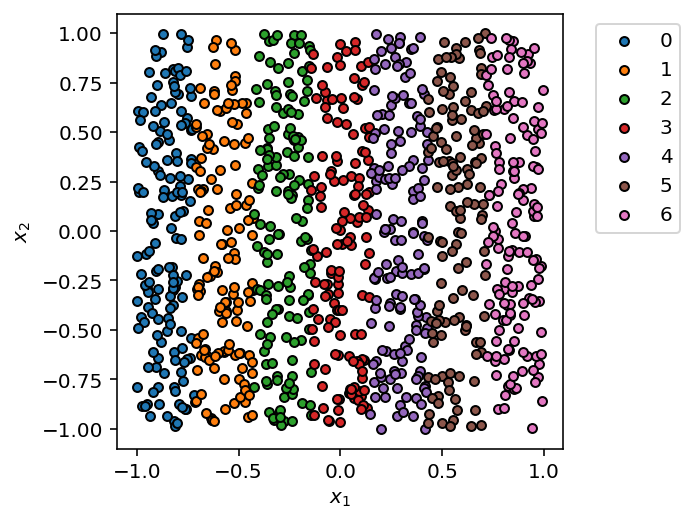

In [6]:
def accuracy_score(y_true, y_pred):

    score = y_true == y_pred
    return score.sum() / len(y_true)


def data_creation(samples, classes=l+1):

    Xvals, yvals = [], []
    lin_range = 2/classes
    
    start = -1

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        for j in range(classes):
            if x[0] < start+lin_range*(j+1):
                y = j
                break
        
        Xvals.append(x)
        yvals.append(y*2)
    return np.array(Xvals), np.array(yvals)




def plot_data(x, y, fig=None, ax=None, title=None, classes=l+1):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for j in range(classes):
        dots = y == 2*j
        #print(j)
        ax.scatter(x[dots, 0], x[dots, 1], s=20, edgecolor="k", label=j)

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1.05, 1))


Xdata, ydata = data_creation(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)

def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Th following functions are the jitted, vectorized versions of the cost and test function.

In [7]:
@jit
def vmap_cost(params, X_batched, y_batched):
    return vmap(cost_circ,  in_axes=(None, 0, 0))(params, X_batched, y_batched).sum()/len(X_batched)

@jit
def vmap_cost_ind(params, X_batched, y_batched, beta=0.3):
    return vmap(cost_circ,  in_axes=(None, 0, 0, None, None))(params, X_batched, y_batched, beta, True)

@jit
def vmap_test(params, X_batched, state_labels):
    return vmap(test,  in_axes=(None, 0, None))(params, X_batched, state_labels)


cost_circ_grad = grad(vmap_cost, argnums=0)

We then need the gradient of the cost function.

In [8]:
cost_circ_grad = grad(vmap_cost, argnums=0)

Now we have everything we need and can start learning. We first need to create the dataset and choose random parameters to start.

In [11]:
state_labels_flat = np.array(used_labels).flatten()

x_data, y_data = data_creation(2000)


batch_size = 100

x_data, y_data = shuffle(x_data, y_data)


train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)


used_labels_arr = np.array(used_labels)[:, 0]

In [13]:
print(used_labels_arr)

[ 0  2  4  6  8 10 12]


We now have our data and can start learning. We will start by choosing $\beta=1$. 

In [14]:
num_layers_list = [2, 3, 4, 5, 6, 7, 8, 9]
np.random.seed(2)




batch_size = 50

num_params = 4


for num_layer in num_layers_list:

    for j in tqdm(range(20)):
        x_data, y_data = data_creation(1000)
        x_data, y_data = shuffle(x_data, y_data)
        train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)
        
        #print("--------------------------------------")
        #print(f"Starting Learning with {num_layer} layer(s)!")

        params = np.random.uniform(size=(num_layer, num_params))*np.pi/2

        params[:, 3] = 0
        beta=0

        losses = []
        train_acc = []
        param_list = []

        epochs = 40

        learning_rate = 0.05
        opt = AdamOptimizer(learning_rate)

        for i in range(epochs):
            #print("--------------------------------------")
            #print(f"Starting Epoch {i+1}, learning rate: {learning_rate:.2f}")

            x_train, y_train = shuffle(train_x, train_y)
            for X_Batch, Y_Batch in iterate_minibatches(x_train, y_train, batch_size):
                #print(X_Batch.shape, Y_Batch.shape)
                params = opt.step(vmap_cost, params, grad_fn=cost_circ_grad, X_batched=X_Batch, y_batched=Y_Batch)
            param_list.append(params)
            pred_test = vmap_test(params, test_x, state_labels_flat)
            pred_test = np.array(pred_test)
            for n, prediction in enumerate(pred_test):
                pred_test[n] = used_labels_arr[prediction]
            acc = accuracy_score(test_y, pred_test)
            loss = vmap_cost(params, train_x, train_y)


            losses.append(loss)
            train_acc.append(acc)
            #print(f"Epoch {i+1}, Loss: {loss:.3f}, Accuracy: {acc:.3f}")
            #print(params)

        np.save(f"Data_Lin_Multi_Squeez_Double/params_{num_layer}-layers-{j}.npy", param_list)
        np.save(f"Data_Lin_Multi_Squeez_Double/loss_{num_layer}-layers-{j}.npy", losses)
        np.save(f"Data_Lin_Multi_Squeez_Double/acc_{num_layer}-layers-{j}.npy", train_acc)






100%|██████████| 20/20 [42:07<00:00, 126.35s/it] 
